<h1>TEXT SUMMARIZTION WITH AMAZON-REVIEWS</h1>

In [1]:
from distutils.version import LooseVersion
import tensorflow as tf
from tensorflow.python.layers.core import Dense


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
!python3.6 -m pip install tensorflow==1.15

In [2]:
import tensorflow as tf
print(tf.__version__)
dir(tf.contrib.rnn)

1.15.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



['AttentionCellWrapper',
 'BasicLSTMCell',
 'BasicRNNCell',
 'BidirectionalGridLSTMCell',
 'CompiledWrapper',
 'Conv1DLSTMCell',
 'Conv2DLSTMCell',
 'Conv3DLSTMCell',
 'ConvLSTMCell',
 'CoupledInputForgetGateLSTMCell',
 'DeviceWrapper',
 'DropoutWrapper',
 'EmbeddingWrapper',
 'FusedRNNCell',
 'FusedRNNCellAdaptor',
 'GLSTMCell',
 'GRUBlockCell',
 'GRUBlockCellV2',
 'GRUCell',
 'GridLSTMCell',
 'HighwayWrapper',
 'IndRNNCell',
 'IndyGRUCell',
 'IndyLSTMCell',
 'InputProjectionWrapper',
 'IntersectionRNNCell',
 'LSTMBlockCell',
 'LSTMBlockFusedCell',
 'LSTMBlockWrapper',
 'LSTMCell',
 'LSTMStateTuple',
 'LayerNormBasicLSTMCell',
 'LayerRNNCell',
 'MultiRNNCell',
 'NASCell',
 'OutputProjectionWrapper',
 'PhasedLSTMCell',
 'RNNCell',
 'ResidualWrapper',
 'SRUCell',
 'TimeFreqLSTMCell',
 'TimeReversedFusedRNN',
 'UGRNNCell',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'best_effort_input_batch_size',
 'stack

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import gzip
import codecs
import re
import time
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from tensorflow.python.layers.core import Dense
from tensorflow.contrib.rnn import GRUCell, DropoutWrapper
from tensorflow.contrib.seq2seq import TrainingHelper, GreedyEmbeddingHelper,BasicDecoder, dynamic_decode, \
 BahdanauAttention, AttentionWrapper,sequence_loss
import helper

TOKEN_GO = '<GO>'
TOKEN_EOS = '<EOS>'
TOKEN_PAD = '<PAD>'
TOKEN_UNK = '<UNK>'

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from numpy import linalg as LA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [6]:
import os
os.listdir('/content/gdrive/My Drive')
! rm /content/gdrive/My Drive/best*

rm: cannot remove '/content/gdrive/My': No such file or directory
rm: cannot remove 'Drive/best*': No such file or directory


In [0]:
#titledata=[]
#artdata=[]
#with gzip.open('/content/gdrive/My Drive/news.txt.gz') as artfile:
#    for li in artfile:
#        artdata.append(li.decode())
#with gzip.open('/content/gdrive/My Drive/summary.txt.gz') as titlefile:
#    for li in titlefile:
#        titledata.append(li.decode())
#news = pd.DataFrame({'Text':artdata,'Summary':titledata})
#news = news.sample(frac=0.5)
#news['Text_len'] = news.Text.apply(lambda x: len(x.split()))
#news['Summary_len'] = news.Summary.apply(lambda x: len(x.split()))

In [0]:
data_new=pd.read_csv('/content/gdrive/My Drive/data_new.csv')

In [9]:
news=data_new[['cleaned_text','cleaned_summary']]
news=news.rename(columns={'cleaned_text':'Text','cleaned_summary':'Summary'})
news['Text_len'] = news.Text.apply(lambda x: len(x.split()))
news['Summary_len'] = news.Summary.apply(lambda x: len(x.split()))
news.head()

,Text,Summary,Text_len,Summary_len
0,bought several vitality canned dog food produc...,good quality dog food,23,4
1,product arrived labeled jumbo salted peanuts p...,not as advertised,18,3
2,confection around centuries light pillowy citr...,delight says it all,39,4
3,looking secret ingredient robitussin believe f...,cough medicine,17,2
4,great taffy great price wide assortment yummy ...,great taffy,13,2


In [10]:
print(news['Text'].head(5).values)
print(news['Summary'].head(5).values)

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo'
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch'
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal'
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']
['good quality dog food ' 'not as advertised ' 'delight says it all '
 'cough medicine ' 'great taffy ']


In [0]:
news_summaries = []
for summary in news.Summary:
    news_summaries.append(summary)
news_texts = []
for text in news.Text:
    news_texts.append(text)

In [0]:
def count_words(words_dict, text):
    for sentence in text:
        for word in sentence.split():
            if word not in words_dict:
                words_dict[word] = 1
            else:
                words_dict[word] += 1

In [13]:
word_counts_dict = {}
count_words(word_counts_dict, news_summaries)
count_words(word_counts_dict, news_texts)
            
print("Total words in Vocabulary:", len(word_counts_dict))

Total words in Vocabulary: 56955


In [0]:
if 'glove.6B.50d.txt' not in os.listdir('/content/'):
  !unzip /content/gdrive/My\ Drive/glove6b50dtxt.zip

In [0]:
def build_word_vector_matrix(vector_file):
    embedding_index = {}
    with codecs.open(vector_file, 'r', 'utf-8') as f:
        for i, line in enumerate(f):
            sr = line.split()
            if(len(sr)<26):
                continue
            word = sr[0]
            embedding = np.asarray(sr[1:], dtype='float32')
            embedding_index[word] = embedding
    return embedding_index
# Replace the path here to point to the glove.6B.50d.txt vectors file on your system
embeddings_index = build_word_vector_matrix('/content/glove.6B.50d.txt')

In [0]:
word2int = {} 
count_threshold = 20
value = 0
for word, count in word_counts_dict.items():
    if count >= count_threshold or word in embeddings_index:
        word2int[word] = value
        value += 1


special_codes = [TOKEN_UNK,TOKEN_PAD,TOKEN_EOS,TOKEN_GO]   

for code in special_codes:
    word2int[code] = len(word2int)

int2word = {}
for word, value in word2int.items():
    int2word[value] = word

In [17]:
embedding_dim = 50
nwords = len(word2int)

word_emb_matrix = np.zeros((nwords, embedding_dim), dtype=np.float32)
for word, i in word2int.items():
    if word in embeddings_index:
        word_emb_matrix[i] = embeddings_index[word]
    else:
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        word_emb_matrix[i] = new_embedding
print("Length of word embeddings: ", len(word_emb_matrix))

Length of word embeddings:  36805


In [0]:
def convert_sentence_to_ids(text, eos=False):
    wordints = []
    word_count = 0
    for sentence in text:
        sentence2ints = []
        for word in sentence.split():
            word_count += 1
            if word in word2int:
                sentence2ints.append(word2int[word])
            else:
                sentence2ints.append(word2int[TOKEN_UNK])
        if eos:
            sentence2ints.append(word2int[TOKEN_EOS])
        wordints.append(sentence2ints)
    return wordints, word_count

In [0]:
id_summaries, word_count = convert_sentence_to_ids(news_summaries)
id_texts, word_count = convert_sentence_to_ids(news_texts, eos=True)

In [0]:
def unknown_tokens(sentence):
    unk_token_count = 0
    for word in sentence:
        if word == word2int[TOKEN_UNK]:
            unk_token_count += 1
    return unk_token_count

In [0]:
news_summaries_filtered = []
news_texts_filtered = []
max_text_length = int(news.Text_len.mean() + news.Text_len.std())
max_summary_length = int(int(news.Summary_len.mean() + news.Summary_len.std()))
min_length = 4
unknown_token_text_limit = 10
unknown_token_summary_limit = 4

for count,text in enumerate(id_texts):
    unknown_token_text = unknown_tokens(id_texts[count])
    unknown_token_summary = unknown_tokens(id_summaries[count])
    text_len = len(id_texts[count])
    summary_len = len(id_summaries[count])
    if((unknown_token_text>unknown_token_text_limit) or (unknown_token_summary>unknown_token_summary_limit)):
        continue
    if(text_len<min_length or summary_len<min_length or text_len>max_text_length or summary_len>max_summary_length):
        continue
    news_summaries_filtered.append(id_summaries[count])
    news_texts_filtered.append(id_texts[count])

In [0]:
def model_inputs():
    inputs_data = tf.placeholder(tf.int32, [None, None], name='input_data')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    dropout_probs = tf.placeholder(tf.float32, name='dropout_probs')
    summary_len = tf.placeholder(tf.int32, (None,), name='summary_len')
    max_summary_len = tf.reduce_max(summary_len, name='max_summary_len')
    text_len = tf.placeholder(tf.int32, (None,), name='text_len')
    return inputs_data, targets, learning_rate, dropout_probs, summary_len, max_summary_len, text_len

In [0]:
def process_encoding_input(target_data, word2int, batch_size):
    ending = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    decoding_input = tf.concat([tf.fill([batch_size, 1], word2int[TOKEN_GO]), ending], 1)
    return decoding_input

In [0]:
def get_cell(csize,dprob):
    rnc = GRUCell(csize)
    rnc = DropoutWrapper(rnc, input_keep_prob = dprob)
    return rnc

def encoding_layer(csize, len_s, nl, rinp, dprob):
    for l in range(nl):
        with tf.variable_scope('encoding_l_{}'.format(l)):
            rnn_frnt = get_cell(csize,dprob)
            rnn_bkwd = get_cell(csize,dprob)
            eop, est = tf.nn.bidirectional_dynamic_rnn(rnn_frnt, rnn_bkwd, 
                                                                    rinp,
                                                                    len_s,
                                                                    dtype=tf.float32)
    eop = tf.concat(eop,nl)
    return eop, est

In [0]:
def trng_dec_layer(dec_emb_inp, summ_len, cell_dec, st_init, lyr_op, 
                            v_size, max_summ_len):
    helper = TrainingHelper(inputs=dec_emb_inp,sequence_length=summ_len, time_major=False)
    dec = BasicDecoder(cell_dec,helper,st_init,lyr_op) 
    logits, _, _ = dynamic_decode(dec,output_time_major=False,impute_finished=True, 
                                  maximum_iterations=max_summ_len)
    return logits

In [0]:
def infr_dec_layer(embeddings, start_token, end_token, decoding_cell, initial_state, op_layer,
                             max_summary_len, batch_size):
    
    start_tokens = tf.tile(tf.constant([start_token], dtype=tf.int32), [batch_size], name='start_tokens')
    inf_helper = GreedyEmbeddingHelper(embeddings,start_tokens,end_token)
    inf_decoder = BasicDecoder(decoding_cell,inf_helper,initial_state,op_layer)       
    inf_logits, _, _ = dynamic_decode(inf_decoder,output_time_major=False,impute_finished=True,
                                                            maximum_iterations=max_summary_len)
    return inf_logits

In [0]:
def decoding_layer(dec_emb_op, embs, enc_op, enc_st, v_size, txt_len, 
                   summ_len,mx_summ_len, rnsize, word2int, dprob, batch_size, nlyrs):
    
    for l in range(nlyrs):
        with tf.variable_scope('dec_rnn_layer_{}'.format(l)):
            gru = tf.contrib.rnn.GRUCell(rnn_len)
            cell_dec = tf.contrib.rnn.DropoutWrapper(gru,input_keep_prob = dprob)
            
    out_l = Dense(v_size, kernel_initializer = tf.truncated_normal_initializer(mean = 0.0, stddev=0.1))
    
    attention = BahdanauAttention(rnsize, enc_op,txt_len,
                                                  normalize=False,
                                                  name='BahdanauAttention')
    cell_dec =  AttentionWrapper(cell_dec,attention,rnn_len)
    attn_zstate = cell_dec.zero_state(batch_size , tf.float32 )
    attn_zstate = attn_zstate.clone(cell_state = enc_st[0])
    with tf.variable_scope("decoding_layer"):
        tr_dec_op = trng_dec_layer(dec_emb_op, 
                                                  summ_len, 
                                                  cell_dec, 
                                                  attn_zstate,
                                                  out_l,
                                                  v_size, 
                                                  mx_summ_len)
    with tf.variable_scope("decoding_layer", reuse=True):
        inf_dec_op = infr_dec_layer(embs,  
                                                    word2int[TOKEN_GO], 
                                                    word2int[TOKEN_EOS],
                                                    cell_dec, 
                                                    attn_zstate, 
                                                    out_l,
                                                    mx_summ_len,
                                                    batch_size)

    return tr_dec_op, inf_dec_op

In [0]:
def seq2seq_model(data_inp, data_summ_tgt, dprob, len_txt, len_summ, max_len_summ, 
                  v_size, rnsize, nlyrs, word2int, batch_size):
    
    inp_emb = word_emb_matrix
    word_embs = tf.Variable(inp_emb, name="word_embs")
    inp_enc_emb = tf.nn.embedding_lookup(word_embs, data_inp)
    op_enc, st_enc = encoding_layer(rnsize, len_txt, nlyrs, inp_enc_emb, dprob)
    
    inp_dec = process_encoding_input(data_summ_tgt, word2int, batch_size)
    inp_dec_emb = tf.nn.embedding_lookup(inp_emb, inp_dec)
    
    op_tr, op_inf  = decoding_layer(inp_dec_emb, 
                                                        inp_emb,
                                                        op_enc,
                                                        st_enc, 
                                                        v_size, 
                                                        len_txt, 
                                                        len_summ, 
                                                        max_len_summ,
                                                        rnsize, 
                                                        word2int, 
                                                        dprob, 
                                                        batch_size,
                                                        nlyrs)
    
    return op_tr, op_inf

In [0]:
def pad_sentences(sentences_batch):

    max_sentence = max([len(sentence) for sentence in sentences_batch])
    return [sentence + [word2int[TOKEN_PAD]] * (max_sentence - len(sentence)) for sentence in sentences_batch]

In [0]:
def get_batches(summaries, texts, batch_size):
    for batch_idx in range(0, len(texts)//batch_size):
        start_idx = batch_idx * batch_size
        summaries_batch = summaries[start_idx:start_idx + batch_size]
        texts_batch = texts[start_idx:start_idx + batch_size]
        pad_summaries_batch = np.array(pad_sentences(summaries_batch))
        pad_texts_batch = np.array(pad_sentences(texts_batch))

        pad_summaries_lens = []
        for summary in pad_summaries_batch:
            pad_summaries_lens.append(len(summary))
        
        pad_texts_lens = []
        for text in pad_texts_batch:
            pad_texts_lens.append(len(text))
        
        yield pad_summaries_batch, pad_texts_batch, pad_summaries_lens, pad_texts_lens

In [0]:
def train_on_batch(session, X, X_seq_len, Y, Y_seq_len, learning_rate, dropout_keep_probability):
    feed_dict = {
            data_inp: X,
            tgts:Y,
            lrt:learning_rate,
            len_summ:Y_seq_len,
            len_txt: X_seq_len,
            dprobs: dropout_keep_probability}

    _,pred,loss,summary = session.run([
            train_op,
            tr_cost,
            inf_op,
            merged_summary_op], feed_dict=feed_dict)
    return _,pred, loss, summary

In [0]:
def predict_for_batch(session, X, X_seq_len,Y, Y_seq_len,dropout_keep_probability):

    feed_dict={data_inp:X, len_txt:X_seq_len,tgts:Y, len_summ: Y_seq_len,dprobs: dropout_keep_probability}

    pred = session.run([inf_op], feed_dict=feed_dict)[0]

    return pred


In [0]:

def predict_for_batch_with_loss(session, X, X_seq_len, Y, Y_seq_len,learning_rate,dropout_keep_probability):
    
    feed_dict={data_inp:X, len_txt:X_seq_len, tgts:Y, len_summ: Y_seq_len,lrt:learning_rate,dprobs: dropout_keep_probability}
    
    _,loss,pred = session.run([train_op,tr_cost,infer_predictions], feed_dict=feed_dict)
    
    return pred, loss

In [0]:
batch_size =64
rnn_len =128
n_layers = 2
lr = 0.005
dr_prob =0.75
! rm /content/gdrive/My\ Drive/best*
logs_path='/content/gdrive/My Drive/'

In [35]:
train_graph = tf.Graph()
with train_graph.as_default():
    
    data_inp, tgts, lrt, dprobs, len_summ, max_len_summ, len_txt = model_inputs()

    tr_opp, inf_opp = seq2seq_model(tf.reverse(data_inp, [-1]),
                                                      tgts, 
                                                      dprobs,   
                                                      len_txt,
                                                      len_summ,
                                                      max_len_summ,
                                                      len(word2int)+1,
                                                      rnn_len, 
                                                      n_layers, 
                                                      word2int,
                                                      batch_size)
    
    tr_op = tf.identity(tr_opp.rnn_output, 'tr_op')
    inf_op = tf.identity(inf_opp.sample_id, name='predictions')
    
    seq_masks = tf.sequence_mask(len_summ, max_len_summ, dtype=tf.float32, name='masks')

    with tf.name_scope("optimizer"):
        tr_cost = sequence_loss(tr_op,tgts,seq_masks)
        optzr = tf.train.RMSPropOptimizer(lr)
        grds = optzr.compute_gradients(tr_cost)
        capped_grds = [(tf.clip_by_value(grd, -5., 5.), var) for grd, var in grds 
                        if grd is not None]
        train_op = optzr.apply_gradients(capped_grds)
    # Get predictions for evaluation.
    train_predictions = tr_opp.sample_id
    infer_predictions = inf_opp.sample_id
    tf.summary.scalar("cost", tr_cost)
print("Graph created.")

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Graph created.


In [0]:
def text_to_seq(text):
    return [word2int.get(word, word2int[TOKEN_UNK]) for word in text.split()]

In [0]:
# Program to measure similarity between  
# two sentences using cosine similarity. 
def mean_absolute_error_texts(v1,v2):
    meanerrorl2=[]
    NN=len(v1)
    N2=np.sqrt(NN)
    for X,Y in zip(v1,v2):
        # tokenization 
        X_list = word_tokenize(X)  
        Y_list = word_tokenize(Y) 
  
        # sw contains the list of stopwords 
        sw = stopwords.words('english')  
        l1 =[];l2 =[] 
  
        # remove stop words from string 
        X_set = {w for w in X if not w in sw}  
        Y_set = {w for w in Y if not w in sw} 
  
        # form a set containing keywords of both strings  
        rvector = X_set.union(Y_set)  
        for w in rvector: 
            if w in X_set:
               l1.append(1) # create a vector 
            else:
               l1.append(0) 
            if w in Y_set:
               l2.append(1) 
            else:
               l2.append(0) 
        c = 0
        # cosine formula  
        for i in range(len(rvector)): 
                      c+= l1[i]*l2[i] 
        den=float((sum(l1)*sum(l2))**0.5)
        try: 
           cosine = c /den
        except:
           cosine=0.0 
        meanerrorl2.append(cosine/N2) 
  
    return LA.norm(meanerrorl2,2)*100.0
      

In [38]:
len(news_summaries_filtered)

27125

In [39]:
len(news_texts_filtered)

27125

In [0]:
epochs =25
min_learning_rate = 0.0006
display_step = 400
display_plot = display_step
early_stop_cnt = 0 
early_stop_cnt_max = 3 
per_epoch = 3 


update_loss = 0 
batch_loss = 0
summary_update_loss = [] 

news_summaries_train = news_summaries_filtered[0:21700]
news_texts_train = news_texts_filtered[0:21700]

news_summaries_test =news_summaries_filtered[21700:]
news_texts_test=news_texts_filtered[21700:]

pad = word2int[TOKEN_PAD] 
eos = word2int[TOKEN_EOS]  
unk = word2int[TOKEN_UNK]
tokens_id=[eos,pad,unk]

update_check = (len(news_texts_train)//batch_size//per_epoch)-1
checkpoint = logs_path + 'best_so_far_model.ckpt' 


In [41]:
invalid_number_prediction_counts = []
all_model_predictions = []
all_ground_truth = []
history=[]
print('Start training... \n')

with tf.Session(graph=train_graph) as sess:
    tf_summary_writer = tf.summary.FileWriter(logs_path, graph=train_graph)
    merged_summary_op = tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    for epoch_i in range(epochs):
        update_loss = 0
        batch_loss = 0
        train_loss =0
        for batch_i, (summaries_batch, texts_batch, summaries_len, texts_len) in enumerate(
                get_batches(news_summaries_train, news_texts_train, batch_size)):
            before = time.time()
            _,loss,predictions,summary=train_on_batch(sess,texts_batch, texts_len, summaries_batch, summaries_len, lr, dr_prob)
            #_,loss,summary = sess.run(
            #    [train_op, tr_cost,merged_summary_op],
            #    {data_inp: texts_batch,
            #     tgts: summaries_batch,
            #     lrt: lr,
            #     len_summ: summaries_len,
            #     len_txt: texts_len,
            #     dprobs: dr_prob})
            
            batch_loss += loss
            update_loss += loss
            after = time.time()
            batch_time = after - before
            tf_summary_writer.add_summary(summary, epoch_i * batch_size + batch_i)
            
            if batch_i % display_step == 0 and batch_i > 0:
                print('** Epoch {:>3}/{} Batch {:>4}/{} - Batch Loss: {:>6.3f}, seconds: {:>4.2f}'
                      .format(epoch_i+1,
                              epochs, 
                              batch_i, 
                              len(news_texts_filtered) // batch_size, 
                              batch_loss / display_step, 
                              batch_time*display_step))
                if ((epoch_i/5==0) and (epoch_i>0)):
                         history=pd.DataFrame(history, columns=['epochs','loss','val_loss'])
                         from matplotlib import pyplot 
                         pyplot.plot(history['epochs'],history['loss'], label='train') 
                         pyplot.plot(history['epochs'],history['val_loss'], label='test') 
                         pyplot.legend() 
                         pyplot.show() 
                batch_loss = 0
            
            if batch_i % update_check == 0 and batch_i > 0:
                print("Average loss:", round(update_loss/update_check,3))
                train_loss=round(update_loss/update_check,3)
                summary_update_loss.append(update_loss)
                
                if update_loss <= min(summary_update_loss):
                    print('Saving model') 
                    early_stop_cnt = 0
                    saver = tf.train.Saver() 
                    saver.save(sess, checkpoint)

                else:
                    print("No Improvement.")
                    early_stop_cnt += 1
                    if early_stop_cnt == early_stop_cnt_max:
                        break
                update_loss = 0
            

        summaries_test_batch, texts_test_batch, summaries_test_len, texts_test_len =\
         next(get_batches(news_summaries_test, news_texts_test, batch_size))
    
        predictions,test_loss = predict_for_batch_with_loss(sess,texts_test_batch, texts_test_len,summaries_test_batch,summaries_test_len,lr,1.0)
        history.append([epoch_i+1,train_loss,test_loss])
        #print('history:',history[-1])
        print(" ")  
        print('Test: epoch', epoch_i+1, 'loss:', test_loss,)
        print(" ")
        for text, summary, result_logits  in list(zip(texts_test_batch, summaries_test_batch, predictions))[-3:]: 
                     print('\nText')
                     print('  Word Ids:    {}'.format([i for i in text]))
                     print('  Input Words: {}'.format(" ".join( int2word[i] for i in text if i not in tokens_id)))

                     print('\nSummary')
                     print('  Word Ids:       {}'.format([i for i in result_logits if i not in tokens_id]))
                     print('  Response Words: {}'.format(" ".join(int2word[i] for i in result_logits if i not in tokens_id )))
                     print(' Ground Truth: {}'.format(" ".join(int2word[i] for i in summary if i not in tokens_id)))
                     print('')
        model_predictions = []
        ground_truth = []
        invalid_number_prediction_count = 0

        ind=0
        for summaries_test_batch, texts_test_batch, summaries_test_len, texts_test_len\
         in get_batches(news_summaries_test,news_texts_test, batch_size=batch_size):
                 
  
                 #summaries_test_len=[np.random.randint(5,8)]
                 pred=predict_for_batch(sess, texts_test_batch, texts_test_len,summaries_test_batch,summaries_test_len,1.0)   
                 
                 for y,p in list(zip(summaries_test_batch,pred)): 
                     Y=''.join(int2word[i] for i in y if i not in tokens_id)
                     O=''.join(int2word[i] for i in p if i not in tokens_id)
                     
                     if mean_absolute_error_texts([Y],[O])<1e-15 : 
                             invalid_number_prediction_count += 1
                     lmin=min(len(Y),len(O))+1
                     OO=O[:lmin]
                     YY=Y[:lmin] 
                     model_predictions.append(OO)
                     ground_truth.append(YY)
        all_model_predictions.append(model_predictions)
        all_ground_truth.append(ground_truth)
        invalid_number_prediction_counts.append(invalid_number_prediction_count)
        
        if early_stop_cnt == early_stop_cnt_max:
            print("Stopping Training.")
            break        


Start training... 

Average loss: 8.629
Saving model
Average loss: 5.939
Saving model
Average loss: 5.31
Saving model
 
Test: epoch 1 loss: 5.244236
 

Text
  Word Ids:    [25, 2127, 258, 165, 1890, 156, 83, 2296, 496, 13, 145, 1032, 61, 181, 81, 82, 36803, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802, 36802]
  Input Words: best afternoon snack ever put bag way school work great source protein product natural gluten free

Summary
  Word Ids:       [13, 70, 17, 25]
  Response Words: great for the best
 Ground Truth: great gluten free snack


Text
  Word Ids:    [13305, 746, 845, 1017, 695, 1472, 1458, 1445, 1017, 3178, 2545, 60, 4367, 149, 1064, 771, 433

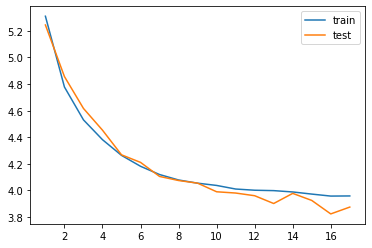

In [42]:
history=pd.DataFrame(history, columns=['epochs','loss','val_loss'])
from matplotlib import pyplot 
pyplot.plot(history['epochs'],history['loss'], label='train') 
pyplot.plot(history['epochs'],history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [43]:
history

,epochs,loss,val_loss
0,1,5.310,5.244236
1,2,4.778,4.856505
2,3,4.531,4.616913
3,4,4.382,4.453537
4,5,4.264,4.268192
5,6,4.182,4.211289
6,7,4.120,4.105628
7,8,4.079,4.075004
8,9,4.055,4.055135
9,10,4.038,3.990360


In [0]:
#Evaluate results¶
#Because our task is simple and the output is straight-forward, we will use MAE metric to evaluate the trained model during the epochs. Compute the value of the metric for the output from each epoch.


In [45]:
for i, (gts, predictions, invalid_number_prediction_count) in enumerate(zip(all_ground_truth,
                                                                            all_model_predictions,
                                                                            invalid_number_prediction_counts), 1):
       

          mae=mean_absolute_error_texts(gts, predictions)
          print("Epoch: %i, MAE: %f, Invalid numbers: %i" % (i, mae, invalid_number_prediction_count))

Epoch: 1, MAE: 57.898399, Invalid numbers: 63
Epoch: 2, MAE: 58.339805, Invalid numbers: 127
Epoch: 3, MAE: 57.279348, Invalid numbers: 165
Epoch: 4, MAE: 58.127807, Invalid numbers: 104
Epoch: 5, MAE: 58.862261, Invalid numbers: 82
Epoch: 6, MAE: 58.971174, Invalid numbers: 69
Epoch: 7, MAE: 59.096178, Invalid numbers: 81
Epoch: 8, MAE: 59.566813, Invalid numbers: 60
Epoch: 9, MAE: 59.393306, Invalid numbers: 74
Epoch: 10, MAE: 59.582851, Invalid numbers: 50
Epoch: 11, MAE: 59.891960, Invalid numbers: 47
Epoch: 12, MAE: 59.829067, Invalid numbers: 50
Epoch: 13, MAE: 59.680285, Invalid numbers: 52
Epoch: 14, MAE: 59.614254, Invalid numbers: 55
Epoch: 15, MAE: 59.790584, Invalid numbers: 49
Epoch: 16, MAE: 59.844391, Invalid numbers: 46
Epoch: 17, MAE: 59.562348, Invalid numbers: 44


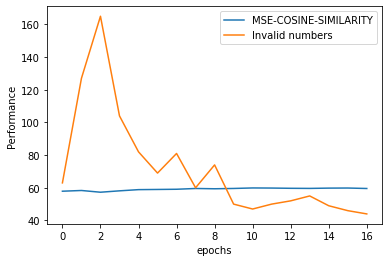

In [11]:
import pandas as pd
Epochs=range(1,18)
msec={}
msec['MSE-COSINE-SIMILARITY']=[ 57.898399,58.339805, 57.279348, 58.127807,58.862261, 58.971174, 59.096178,59.566813,
    59.393306, 59.582851, 59.891960, 59.829067,59.680285, 59.614254, 59.790584, 59.844391, 59.562348] 
msec['Invalid numbers']=[63,127,165,104,82,69,81,60,74,50, 47,50,52, 55,49,46,44]
msec=pd.DataFrame.from_dict(msec)
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

for name in msec.columns:
    ax.plot(msec[name].values,label=name)

ax.set_xlabel("epochs")
ax.set_ylabel("Performance")
ax.legend(loc='best')


In [46]:

#random = np.random.randint(0,3000)
#text = news_texts_filtered[random]
model_predictions = []
ground_truth = []
invalid_number_prediction_count = 0
checkpoint = logs_path + 'best_so_far_model.ckpt' 
print("\n----Prepare evaluation")
for ii in range(100):
    random = np.random.randint(21700,27125)
    text = news_texts_filtered[random]

    #random = np.random.randint(3000,len(news_texts_filtered))
        
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
                  loader = tf.train.import_meta_graph(checkpoint + '.meta')
                  loader.restore(sess, checkpoint)
                  input_data = loaded_graph.get_tensor_by_name('input_data:0')
                  logits = loaded_graph.get_tensor_by_name('predictions:0')
                  text_length = loaded_graph.get_tensor_by_name('text_len:0')
                  summary_length = loaded_graph.get_tensor_by_name('summary_len:0')
                  keep_prob = loaded_graph.get_tensor_by_name('dropout_probs:0')
                  result_logits = sess.run(logits, {input_data: [text]*batch_size, 
                  summary_length: [np.random.randint(5,8)], 
                  text_length: [len(text)]*batch_size,
                  keep_prob: 1.0})[0] 

                  pad = word2int[TOKEN_PAD] 
                  eos = word2int[TOKEN_EOS] 
                  Y=''.join(int2word[i] for i in result_logits if i !=pad)
                  O=''.join(int2word[i] for i in news_summaries_filtered[random] if i!=pad)
                     
                  if mean_absolute_error_texts([Y],[O]) > 90:
                  
                     print('        ')
                     print('        ')
                     #print('\nOriginal Text:', input_sentence)

                     print('\nText')
                     print('  Word Ids:    {}'.format([i for i in text]))
                     print('  Input Words: {}'.format(" ".join( int2word[i] for i in text if i!=eos)))

                     print('\nSummary')
                     print('  Word Ids:       {}'.format([i for i in result_logits if i != pad]))
                     print('  Response Words: {}'.format(" ".join(int2word[i] for i in result_logits if i!=pad )))
                     print(' Ground Truth: {}'.format(" ".join(int2word[i] for i in news_summaries_filtered[random] if i!=pad)))
                     print('        ')
                     print('        ')
 
model_predictions.append(result_logits)
ground_truth.append(news_summaries_filtered[random])         
print('\n...prepare evaluation finished.')


----Prepare evaluation
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_far_model.ckpt
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/best_so_f

In [47]:
print("Finish ")

Finish 
